In [1]:
import os, random, time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
%matplotlib inline

In [2]:
###########################################################################
### 1. Clone & unzip OMNIGLOT dataset #####################################
###########################################################################
!git clone https://github.com/brendenlake/omniglot.git

Cloning into 'omniglot'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [ ]:
!unzip ./images_background.zip -d .

In [ ]:
!unzip ./images_evaluation.zip -d .

## Codes below were developed with help from:
https://github.com/fangpin/siamese-pytorch

https://towardsdatascience.com/building-a-one-shot-learning-network-with-pytorch-d1c3a5fafa4a

https://github.com/ttchengab/One_Shot_Pytorch/

In [5]:
###########################################################################
### 2. Define Train Dataset ###############################################
###########################################################################
class OmniglotTrainDataset(Dataset):
    
    def __init__(self, root_dir, max_n_data, transform=None):
        super(OmniglotTrainDataset, self).__init__()

        self.root_dir = root_dir
        self.max_n_data = max_n_data
        self.transform = transform
        self.imgs_dict, self.n_classes, self.n_imgs = self.load_images()
    
    def __len__(self):
        ''' Dataset iterates over a list of indices (index) = [0, __len__] '''
        return self.max_n_data
     
    def load_images(self):
        print("Loading training dataset...")
        imgs_dict = {}
        char_i, img_i = 0, 0
        
        # Store data w/ different index key per each character 
        for alphaPath in os.listdir(self.root_dir): # Korean, Greek, ....
            for charPath in os.listdir(os.path.join(self.root_dir,alphaPath)): # ㄱ,ㄴ,ㄷ,...
                imgs_dict[char_i] = []                  
                for imgPath in os.listdir(os.path.join(self.root_dir, alphaPath, charPath)):
                    imgs_dict[char_i].append(
                        Image.open(os.path.join(self.root_dir,alphaPath,charPath,imgPath)).convert('L') #greyscale
                        )
                    img_i += 1
                char_i += 1
        print("DONE: %d char classes & %d total images."%(char_i, img_i))
        
        return imgs_dict, char_i, img_i        


    def __getitem__(self, index):   
        ''' index: Dataset iterates over a list of indices (index) = [0, __len__] '''
        
        # Get an image of a random char class
        char_i = np.random.randint(self.n_classes)
        img1 = random.choice(self.imgs_dict[char_i])
        
        # Get another image of the SAME char class
        if index%2 == 1:
            label = torch.from_numpy(np.array([1.0], dtype=np.float32))            
            img2 = random.choice(self.imgs_dict[char_i])           
            
        # Get an image of a DIFFERENT char class
        else:
            label = torch.from_numpy(np.array([0.0], dtype=np.float32))           
            char_j = np.random.randint(self.n_classes)
            while char_j == char_i:
                char_j = np.random.randint(self.n_classes)
            img2 = random.choice(self.imgs_dict[char_j]) 
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, label

In [6]:
###########################################################################
### 3. Define Test Dataset ################################################
###########################################################################
class NWayOneShotTestSet(Dataset):
    
    def __init__(self, root_dir, max_n_data, n_way, transform=None):
        super(NWayOneShotTestSet, self).__init__()

        self.root_dir = root_dir
        self.max_n_data = max_n_data
        self.n_way = n_way
        self.transform = transform
        self.imgs_dict, self.n_classes, self.n_imgs = self.load_images()
    
    def __len__(self):
        ''' Dataset iterates over a list of indices (index) = [0, __len__] '''
        return self.max_n_data
     
    def load_images(self):
        print("Loading test dataset...")
        imgs_dict = {}
        char_i, img_i = 0, 0
        
        # Store data w/ different index key per each character 
        for alphaPath in os.listdir(self.root_dir): # Korean, Greek, ....
            for charPath in os.listdir(os.path.join(self.root_dir,alphaPath)): # ㄱ,ㄴ,ㄷ,...
                imgs_dict[char_i] = []                  
                for imgPath in os.listdir(os.path.join(self.root_dir, alphaPath, charPath)):
                    imgs_dict[char_i].append(
                        Image.open(os.path.join(self.root_dir,alphaPath,charPath,imgPath)).convert('L') #greyscale
                        )
                    img_i += 1
                char_i += 1
        print("DONE: %d char classes & %d total images."%(char_i, img_i))
        
        return imgs_dict, char_i, img_i        

    def __getitem__(self, index): # index = batch_i
        ''' index: Dataset iterates over a list of indices (index) = [0, __len__] '''
   
        # Get an image of a random char class
        char_i = np.random.randint(self.n_classes)
        img2classify = random.choice(self.imgs_dict[char_i])
        if self.transform: 
            img2classify = self.transform(img2classify)
        
        imgs2compare = [] # N images (1 img/ 1 NOVEL char class)
        label = np.random.randint(self.n_way)
       
        for i in range(self.n_way):
            if i == label:
                img = random.choice(self.imgs_dict[char_i])
            else:
                non_label = np.random.randint(self.n_classes)
                while non_label == label:
                    non_label = np.random.randint(self.n_classes)
                img = random.choice(self.imgs_dict[non_label])
            
            if self.transform:              
                img = self.transform(img)
            
            imgs2compare.append(img)
              
        return img2classify, imgs2compare, torch.from_numpy(np.array([label], dtype = int))

In [7]:
###########################################################################
### 4. Make Dataloaders ###################################################
###########################################################################
data_transforms = transforms.Compose([
                            transforms.RandomAffine(15),
                            transforms.ToTensor()
                            ])
if os.path.exists("training_set.pkl"):
    training_set = pkl.load(open("training_set.pkl", "rb"))
else:
    training_set = OmniglotTrainDataset("images_background", max_n_data=10000, transform=data_transforms)
    pkl.dump(training_set, open("training_set.pkl", "wb"))

train_ratio = 0.8
train_size = int(len(training_set)*train_ratio)
train_data, valid_data = random_split(training_set, [train_size, len(training_set)-train_size])

batch_size = 128
num_workers = 16
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)     

if os.path.exists("test_set.pkl"):
    test_set = pkl.load(open("test_set.pkl", "rb"))
else:
    test_set = NWayOneShotTestSet("images_evaluation", max_n_data=5000, n_way=20, transform=data_transforms)
    pkl.dump(test_set, open("test_set.pkl", "wb"))
    
test_loader = DataLoader(test_set, batch_size=1, num_workers=2, shuffle=True) 

Loading training dataset...
DONE: 964 char classes & 19280 total images.
Loading test dataset...
DONE: 659 char classes & 13180 total images.


tensor([1.])
tensor([1.])
tensor([1.])
tensor([0.])


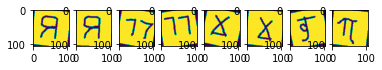

In [8]:
# Show some training examples
for i, (img1, img2, label) in enumerate(train_loader):
    if i >= 1:
        break
   
    plt.subplot(1, 8, 1)
    plt.imshow(img1[0][0])
    plt.subplot(1, 8, 2)
    plt.imshow(img2[0][0])
    print(label[0])
    
    plt.subplot(1, 8, 3)
    plt.imshow(img1[1][0])
    plt.subplot(1, 8, 4)
    plt.imshow(img2[1][0])
    print(label[1])
    
    plt.subplot(1, 8, 5)
    plt.imshow(img1[2][0])
    plt.subplot(1, 8, 6)
    plt.imshow(img2[2][0])
    print(label[2])
    
    plt.subplot(1, 8, 7)
    plt.imshow(img1[3][0])
    plt.subplot(1, 8, 8)
    plt.imshow(img2[3][0])
    print(label[3])
    
    plt.show()
    i += 1

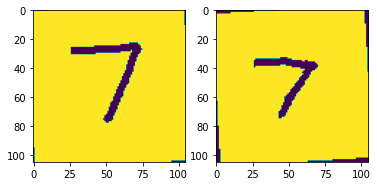

In [9]:
# Show some test examples
for i, (img1, imgs, label) in enumerate(test_loader):
    if i>=1:
        break
    for j, img in enumerate(imgs):
        if j == label[0]:  
            plt.subplot(1, 2, 1)
            plt.imshow(img[0][0])
            plt.subplot(1, 2, 2)
            plt.imshow(img1[0][0])
            plt.show()
            break

In [32]:
###########################################################################
### 5. Define Model #######################################################
###### *NOTE* : BatchNorm after each CNN layer is important! ##############
######### Without it, weight diverges (unchanging train/valid losses) #####
###########################################################################
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        
        # Conv2d(in_channels, out_channels, kernel_size)
        self.conv = nn.Sequential(             # [1, 105, 105]
                        nn.Conv2d(1, 64, 10),  # [64, 96, 96]
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2),       # [64, 48, 48]
                        nn.Conv2d(64, 128, 7), # [128, 42, 42]
                        nn.ReLU(),    
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2),       # [128, 21, 21]
                        nn.Conv2d(128, 128, 4),# [128, 18, 18]
                        nn.ReLU(), 
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2),       # [128, 9, 9]
                        nn.Conv2d(128, 256, 4),# [256, 6, 6]
                        nn.ReLU(), 
                        nn.BatchNorm2d(256),
                    )
        
        self.fc1 = nn.Sequential(nn.Linear(256*6*6, 4096), nn.Sigmoid())
        self.fc_final = nn.Linear(4096, 1)
        
    def forward_one(self, x):
        out = self.conv(x)
        out = out.view(-1, 256*6*6)
        out = self.fc1(out)
    
        return out
    
    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        
        dist_vec = torch.abs(out1 - out2)
        similarity_score = self.fc_final(dist_vec)
        
        return similarity_score

In [33]:
model = SiameseNet()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
    
def count_parameters(
    model):
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Model Architecture:\n", model)
    print("\nThe model has %d trainable parameters.\n"%n_params)

count_parameters(model)

Model Architecture:
 SiameseNet(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1)

In [10]:
###########################################################################
### 6. Define Loss & Optimizer ############################################
###########################################################################
criterion = nn.BCEWithLogitsLoss(size_average=True)
optimizer = optim.Adam(model.parameters(), lr=0.00006)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [35]:
###########################################################################
### 7. Train! #############################################################
###########################################################################
def train(model, criterion, optimizer, 
          n_epochs=100, n_test=200, print_every=20, save_model_path = "model", save_loss_dict_path = "loss_dict"):
    loss_dict = {}
    loss_dict["train_losses"] =  []
    loss_dict["valid_losses"] = []
    loss_dict["test_accs"] = []
    best_test_acc = 0.0
    start = time.time()
      
    prev_save = ""
    for e in range(n_epochs):
        model.train()
        running_loss = 0.0
        for batch_i, (img1, img2, labels) in enumerate(train_loader):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outs = model(img1, img2)
            loss = criterion(outs, labels)            
            running_loss += loss.item()
            optimizer.zero_grad()    
            loss.backward()
            optimizer.step()
            ########################### Validation ############################
            if (batch_i+1) % print_every == 0: 
                model.eval()
                running_loss_val = 0

                with torch.no_grad():
                    for img1, img2, labels in valid_loader:
                        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                        outs = model(img1, img2)
                        loss = criterion(outs, labels)            
                        running_loss_val += loss.item()
                    
                    avg_train_loss = running_loss/print_every
                    loss_dict["train_losses"].append(avg_train_loss)
                    avg_val_loss = running_loss_val/len(valid_loader)
                    loss_dict["valid_losses"].append(avg_val_loss)
                    
                    ######################## One-shot Test ####################
                    correct = 0                
                    for i, (img1, imgs, label) in enumerate(test_loader): 
                        # just test on random 200 test data (contains only NOVEL char classes)
                        if i >= n_test:
                            break
                        img1 = img1.to(device)
                        similarity_scores = []
                        for j, img2 in enumerate(imgs):
                            img2 = img2.to(device)
                            similarity_scores.append( model(img1, img2) )
                        if np.argmax(similarity_scores) == label[0]:
                            correct += 1                       
                    test_acc = correct/n_test
                    loss_dict["test_accs"].append(test_acc)
                    
                    print("Epoch: %d/%d  (batch: %d)  train loss: %.5f  val loss: %.5f  one-shot acc: %.3f  elapsed time(s): %.2f" % 
                              (e+1, n_epochs, batch_i+1, avg_train_loss, avg_val_loss, test_acc, time.time()-start))
                    
                    ## if best 1-shot test accuracy, save model checkpoint & loss_dict ##
                    if test_acc > best_test_acc:                    
                        best_test_acc = test_acc
                        if prev_save:
                            os.remove(save_model_path     + prev_save + ".pt")
                            os.remove(save_loss_dict_path + prev_save + ".pkl")
                        prev_save = "_" + str(e+1) 
                        torch.save(model.state_dict(), save_model_path + prev_save + ".pt")
                        pkl.dump(loss_dict, open(save_loss_dict_path + prev_save + ".pkl", "wb"))

                    running_loss = 0
                    start = time.time()
                    model.train()

    return loss_dict

In [11]:
loss_dict = train(model, criterion, optimizer)

Epoch: 1/100  (batch: 20)  train loss: 0.54127  val loss: 0.74527  one-shot acc: 0.095  elapsed time(s): 20.25
Epoch: 1/100  (batch: 40)  train loss: 0.47233  val loss: 0.44742  one-shot acc: 0.220  elapsed time(s): 18.68
Epoch: 1/100  (batch: 60)  train loss: 0.44843  val loss: 0.43819  one-shot acc: 0.190  elapsed time(s): 18.64
Epoch: 2/100  (batch: 20)  train loss: 0.40546  val loss: 0.33711  one-shot acc: 0.350  elapsed time(s): 20.51
Epoch: 2/100  (batch: 40)  train loss: 0.34903  val loss: 0.36490  one-shot acc: 0.315  elapsed time(s): 18.66
Epoch: 2/100  (batch: 60)  train loss: 0.33435  val loss: 0.31771  one-shot acc: 0.340  elapsed time(s): 18.66
Epoch: 3/100  (batch: 20)  train loss: 0.30893  val loss: 0.28490  one-shot acc: 0.465  elapsed time(s): 20.74
Epoch: 3/100  (batch: 40)  train loss: 0.29939  val loss: 0.26471  one-shot acc: 0.380  elapsed time(s): 18.70
Epoch: 3/100  (batch: 60)  train loss: 0.26005  val loss: 0.30440  one-shot acc: 0.435  elapsed time(s): 18.63
E

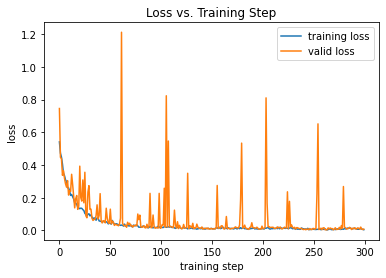

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.plot(loss_dict["train_losses"])
plt.plot(loss_dict["valid_losses"])
plt.title("Loss vs. Training Step")
plt.xlabel("training step")
plt.ylabel("loss")
plt.legend(["training loss", "valid loss"])
plt.show()

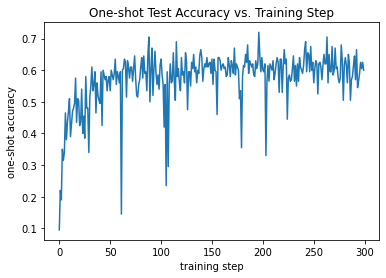

In [ ]:
plt.plot(loss_dict["test_accs"])
plt.title("One-shot Test Accuracy vs. Training Step")
plt.xlabel("training step")
plt.ylabel("one-shot accuracy")
plt.show()

Highest one-shot test accuracy of 72% was achieved, although the accuracies near the last half of the training stage (last 50 epochs) jumped between accuracy of 50s and 60s.

Let's try reducing learnig rate to 0.00006 and train again from scratch.

In [36]:
model = SiameseNet()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00006)
loss_dict2 = train(model, criterion, optimizer, n_epochs=150, n_test=300)

Epoch: 1/150  (batch: 20)  train loss: 0.61554  val loss: 0.64480  one-shot acc: 0.143  elapsed time(s): 26.62
Epoch: 1/150  (batch: 40)  train loss: 0.52537  val loss: 0.48581  one-shot acc: 0.260  elapsed time(s): 25.16
Epoch: 1/150  (batch: 60)  train loss: 0.48492  val loss: 0.44110  one-shot acc: 0.270  elapsed time(s): 25.11
Epoch: 2/150  (batch: 20)  train loss: 0.43634  val loss: 0.40388  one-shot acc: 0.280  elapsed time(s): 27.29
Epoch: 2/150  (batch: 40)  train loss: 0.44196  val loss: 0.42820  one-shot acc: 0.317  elapsed time(s): 25.19
Epoch: 2/150  (batch: 60)  train loss: 0.40987  val loss: 0.39534  one-shot acc: 0.347  elapsed time(s): 25.16
Epoch: 3/150  (batch: 20)  train loss: 0.38335  val loss: 0.34463  one-shot acc: 0.293  elapsed time(s): 27.32
Epoch: 3/150  (batch: 40)  train loss: 0.37985  val loss: 0.33780  one-shot acc: 0.387  elapsed time(s): 25.24
Epoch: 3/150  (batch: 60)  train loss: 0.35953  val loss: 0.34487  one-shot acc: 0.407  elapsed time(s): 25.21
E

KeyboardInterrupt: ignored

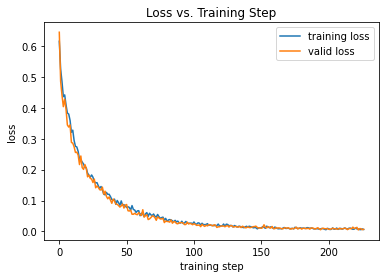

In [ ]:
loss_dict_76 = pkl.load(open("loss_dict_76.pkl", "rb"))
plt.plot(loss_dict_76["train_losses"])
plt.plot(loss_dict_76["valid_losses"])
plt.title("Loss vs. Training Step")
plt.xlabel("training step")
plt.ylabel("loss")
plt.legend(["training loss", "valid loss"])
plt.show()

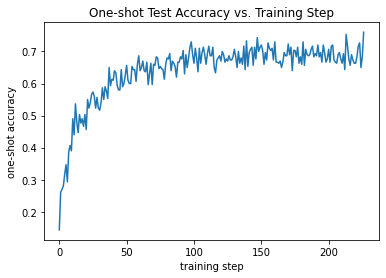

In [ ]:
plt.plot(loss_dict_76["test_accs"])
plt.title("One-shot Test Accuracy vs. Training Step")
plt.xlabel("training step")
plt.ylabel("one-shot accuracy")
plt.show()

Highest one-shot test accuracy of 76% was achieved, although the accuracies near the last half of the training stage (last 50 epochs) jumped between accuracy of 60s and 70s. --> improvement!

In [43]:
# load best model and reduce
model.load_state_dict(torch.load("model_76.pt"))
optimizer = optim.Adam(model.parameters(), lr=0.000006)
loss_dict2 = train(model, criterion, optimizer, n_epochs=50, n_test=300)

Epoch: 1/50  (batch: 20)  train loss: 0.00729  val loss: 0.00712  one-shot acc: 0.707  elapsed time(s): 26.34
Epoch: 1/50  (batch: 40)  train loss: 0.00673  val loss: 0.00523  one-shot acc: 0.720  elapsed time(s): 25.20
Epoch: 1/50  (batch: 60)  train loss: 0.01022  val loss: 0.00495  one-shot acc: 0.737  elapsed time(s): 25.04
Epoch: 2/50  (batch: 20)  train loss: 0.00610  val loss: 0.00535  one-shot acc: 0.713  elapsed time(s): 27.09
Epoch: 2/50  (batch: 40)  train loss: 0.00931  val loss: 0.00525  one-shot acc: 0.683  elapsed time(s): 25.05
Epoch: 2/50  (batch: 60)  train loss: 0.00726  val loss: 0.00446  one-shot acc: 0.683  elapsed time(s): 24.98
Epoch: 3/50  (batch: 20)  train loss: 0.00599  val loss: 0.00410  one-shot acc: 0.693  elapsed time(s): 26.99
Epoch: 3/50  (batch: 40)  train loss: 0.00750  val loss: 0.00366  one-shot acc: 0.697  elapsed time(s): 24.99
Epoch: 3/50  (batch: 60)  train loss: 0.00537  val loss: 0.00416  one-shot acc: 0.707  elapsed time(s): 25.02
Epoch: 4/5

KeyboardInterrupt: ignored

Not much improvement.

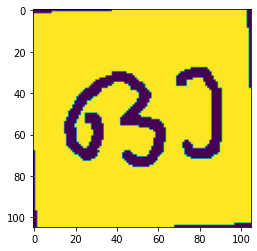

correct novel class prediction!


In [ ]:
# sample novel test class prediction & visualization
random_test_idx = random.choice(range(len(test_loader)))
model.eval()
with torch.no_grad:
    for i, (img1, imgs, label) in enumerate(test_loader): 
        if i==random_test_idx:
            plt.imshow(img1[0][0])
            plt.show()
            img1 = img1.to(device)
            similarity_scores = []
            for j, img2 in enumerate(imgs):
                img2 = img2.to(device)
                similarity_scores.append( model(img1, img2) )
            pred_i = np.argmax(similarity_scores)
            if pred_i == label[0]:
                pred_img = imgs[pred_i][0][0]
                print("correct novel class prediction!")
            break

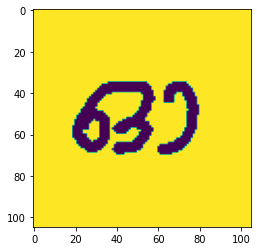

In [ ]:
plt.imshow(pred_img)